In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mahotas

In [2]:
image_path = "/home/duyle/Documents/AIL/rice_seed/BC-15/positive/DSC6771_idx1.png"
image = cv2.imread(image_path)

# Convert to grayscale
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blur = cv2.GaussianBlur(image, (3, 3), 0)
threshold, new_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

contours, _ = cv2.findContours(new_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = max(contours, key=cv2.contourArea)
print(f"Contour area: {cv2.contourArea(contour)}")

Contour area: 8108.5


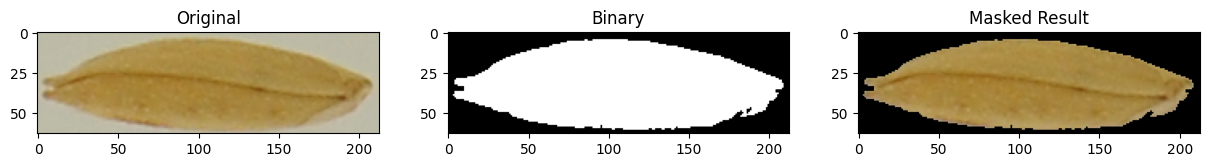

Contour area: 8108.5


In [ ]:
# Load the image
image = cv2.imread(image_path)
original = image.copy()  # Keep a copy of the original for later

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blur = cv2.GaussianBlur(gray, (3,3), 0)  # Increased kernel size

# Apply Otsu's thresholding with BINARY instead of BINARY_INV
threshold, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# If the rice is lighter than background, invert the binary image
if np.mean(gray[binary == 255]) > np.mean(gray[binary == 0]):
    binary = cv2.bitwise_not(binary)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = max(contours, key=cv2.contourArea)

# Create a mask from the contour
mask = np.zeros_like(gray)
cv2.drawContours(mask, [contour], -1, (255), -1) 

# Apply the mask to the original image
masked_image = cv2.bitwise_and(original, original, mask=mask)

# Visualize results
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.subplot(132)
plt.imshow(binary, cmap='gray')
plt.title('Binary')
plt.subplot(133)
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.title('Masked Result')
plt.show()

print(f"Contour area: {cv2.contourArea(contour)}")


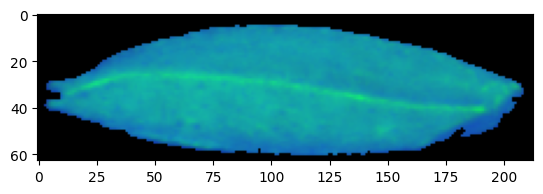

In [5]:
mask_im_gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV)
plt.imshow(mask_im_gray, cmap='gray')

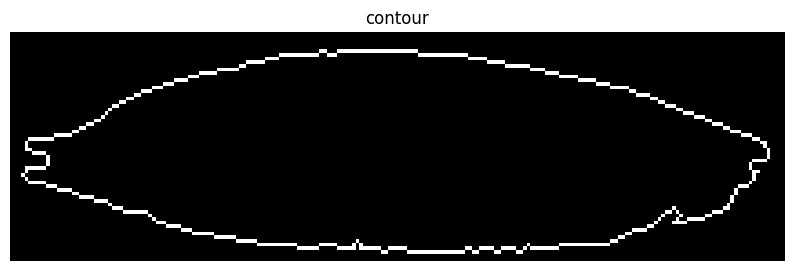

In [6]:
image = cv2.imread(image_path)
original = image.copy() 

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blur = cv2.GaussianBlur(gray, (3,3), 0)  

threshold, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

if np.mean(gray[binary == 255]) > np.mean(gray[binary == 0]):
    binary = cv2.bitwise_not(binary)

contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = max(contours, key=cv2.contourArea)

contour_mask = np.zeros_like(original)

cv2.drawContours(contour_mask, [contour], -1, (255, 255, 255), thickness=1)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(contour_mask, cv2.COLOR_BGR2RGB))
plt.title('contour')
plt.axis('off') 
plt.show()

In [19]:
all_contours = [cv2.contourArea(c) for c in contours]
print(all_contours)  # View the areas of all contours


[8108.5]


In [2]:



# Load the image
image_path = "/home/duyle/Rice_photos/BC-15/positive/DSC6771_idx1.png"  # Update with your image path
image = cv2.imread(image_path)

# Convert to grayscale
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blur = cv2.GaussianBlur(image, (3, 3), 0)
threshold, new_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

contours, _ = cv2.findContours(new_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = max(contours, key=cv2.contourArea)


    # Compute Hu Moments
moments = cv2.moments(contour)
hu_moments = cv2.HuMoments(moments)

# Apply log transformation with a small epsilon to prevent log(0) issues
hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)


print(hu_moments)

[ WARN:0@1.111] global loadsave.cpp:268 findDecoder imread_('/home/duyle/Rice_photos/BC-15/positive/DSC6771_idx1.png'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
from scipy.ndimage import convolve
def extract_edge_histogram_features(image):
    """
    Compute a simplified edge histogram descriptor (EDH) from the image.
    The function applies five convolution kernels corresponding to different edge orientations.
    """
    # Convert to grayscale if necessary.
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Define convolution kernels for five edge types.
    kernels = {
        "vertical": np.array([[-1,  2, -1],
                              [-1,  2, -1],
                              [-1,  2, -1]], dtype=np.float32),
        "horizontal": np.array([[-1, -1, -1],
                                [ 2,  2,  2],
                                [-1, -1, -1]], dtype=np.float32),
        "diag_45": np.array([[-1, -1,  2],
                             [-1,  2, -1],
                             [ 2, -1, -1]], dtype=np.float32),
        "diag_135": np.array([[ 2, -1, -1],
                              [-1,  2, -1],
                              [-1, -1,  2]], dtype=np.float32),
        # A non-directional (Laplacian-like) kernel.
        "non_directional": np.array([[1,  1,  1],
                                     [1, -8,  1],
                                     [1,  1,  1]], dtype=np.float32)
    }
    
    features = {}
    total_energy = 0.0
    
    # Convolve the image with each kernel and compute the energy.
    for key, kernel in kernels.items():
        response = convolve(gray.astype(np.float32), kernel, mode="reflect")
        energy = np.sum(np.abs(response))
        features[f"edge_energy_{key}"] = energy
        total_energy += energy
    
    # Normalize to form a histogram (if total energy > 0).
    if total_energy > 0:
        for key in list(features.keys()):
            features[key] /= total_energy

    return features

In [ ]:
extract_edge_histogram_features(cv2.imread('/home/duyle/Rice_photos/BC-15/BC-15/DSC7436_idx70.png'))

{'edge_energy_vertical': np.float32(0.11537549),
 'edge_energy_horizontal': np.float32(0.246982),
 'edge_energy_diag_45': np.float32(0.16055416),
 'edge_energy_diag_135': np.float32(0.15892461),
 'edge_energy_non_directional': np.float32(0.31816378)}

In [ ]:
def color_structure_descriptor(image, grid_size=(8, 8), bins=32):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    
    height, width = hsv_image.shape[:2]
    cell_h, cell_w = height // grid_size[0], width // grid_size[1]

    
    hist_bins = [bins] 

    
    csd = []

    for row in range(grid_size[0]):
        for col in range(grid_size[1]):
            x_start, y_start = col * cell_w, row * cell_h
            x_end, y_end = x_start + cell_w, y_start + cell_h
            cell = hsv_image[y_start:y_end, x_start:x_end]

            hist = cv2.calcHist([cell], [0], None, hist_bins, [0, 180])
            hist = hist.flatten() 
            hist = hist / hist.sum() if hist.sum() != 0 else hist

            csd.extend(hist)

    return {f"csd_{i}":csd[i] for i in range(len(csd))}


In [ ]:
def edge_density_feature(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)  # Edge detection
    edge_density = np.sum(edges) / (image.shape[0] * image.shape[1])  # Normalize by image size
    return edge_density


In [3]:
image_path = "/home/duyle/Documents/AIL/rice_seed/BC-15/negative/DSC6543_idx5.png"  # Update with your image path
image = cv2.imread(image_path)


In [4]:
from pyefd import elliptic_fourier_descriptors, normalize_efd, reconstruct_contour

In [6]:
def extract_efd_features(image, n_harmonics=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(image, (3, 3), 0)
    threshold, new_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    area = np.count_nonzero(new_img)
    contours, _ = cv2.findContours(new_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    # Preprocess to get contour

    
    # Convert OpenCV contour format to the format expected by PyEFD
    contour_array = contour.reshape(-1, 2)
    
    # Calculate EFD coefficients
    coeffs = elliptic_fourier_descriptors(contour_array, order=n_harmonics, normalize=True)
    
    # Flatten the coefficients into a feature vector
    features = coeffs.flatten()
    
    return features

In [7]:
extract_efd_features(image)

array([ 1.00000000e+00, -1.63849546e-17, -2.23109318e-16, -3.09916031e-01,
        2.95931488e-02, -1.59992690e-02,  2.73633083e-02, -2.05992298e-02,
        6.22834872e-02, -9.88907731e-04,  3.33573312e-02, -2.21300023e-02,
        1.78338960e-02, -1.67408307e-02, -6.67361812e-04, -8.68330419e-03,
        1.33569045e-02, -4.97332668e-03,  1.81737743e-02,  3.95266753e-03,
        6.58239860e-03, -1.89787758e-02, -6.03084834e-03,  7.47268487e-04,
        5.45950677e-03,  1.60588736e-03,  1.54213332e-02, -1.07541685e-03,
        4.03094792e-03, -1.49563242e-02, -1.15260525e-02,  7.01534211e-03,
        5.25896729e-03,  2.14805111e-03,  8.89432096e-03, -3.24629155e-03,
        2.68091917e-03, -1.21926740e-02, -6.92303607e-03,  1.52820512e-03])

In [7]:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(image, (3, 3), 0)
    threshold, new_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    area = np.count_nonzero(new_img)
    contours, _ = cv2.findContours(new_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)

In [26]:
def extract_css_features_fixed(image, num_features=20):
    """Extract Curvature Scale Space features from rice seed contour"""
    # Preprocess image
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(image, (3, 3), 0)
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    
    # Convert to numpy array
    contour_array = contour.reshape(-1, 2)
    
    # Ensure enough points for analysis
    if len(contour_array) < 50:
        # Interpolate to get more points
        t = np.arange(len(contour_array))
        ti = np.linspace(0, t[-1], 100)
        x = np.interp(ti, t, contour_array[:, 0])
        y = np.interp(ti, t, contour_array[:, 1])
        contour_array = np.column_stack((x, y))
    
    # Initialize features
    features = {}
    
    # Define scales for CSS
    scales = np.linspace(1, 10, num_features)
    
    # For each scale, smooth the contour first, then calculate curvature
    for i, sigma in enumerate(scales):
        # Get x and y coordinates
        x = contour_array[:, 0]
        y = contour_array[:, 1]
        
        # Create kernel size based on sigma (must be odd)
        ksize = int(2 * np.ceil(3 * sigma) + 1)
        
        # Use 1D Gaussian filter from scipy instead of OpenCV
        from scipy.ndimage import gaussian_filter1d
        x_smooth = gaussian_filter1d(x, sigma)
        y_smooth = gaussian_filter1d(y, sigma)
        
        # Calculate derivatives of the smoothed contour
        dx = np.gradient(x_smooth)
        dy = np.gradient(y_smooth)
        ddx = np.gradient(dx)
        ddy = np.gradient(dy)
        
        # Calculate curvature
        curvature = np.abs((dx * ddy - dy * ddx) / (dx**2 + dy**2)**(3/2))
        
        # Replace NaN values (from division by zero) with zeros
        curvature = np.nan_to_num(curvature)
        
        # Find zero crossings in curvature
        # For curvature, look for local maxima (peaks) which are more meaningful
        peaks = np.where((curvature[1:-1] > curvature[:-2]) & 
                         (curvature[1:-1] > curvature[2:]))[0] + 1
        
        # Store features
        features[f'css_peaks_scale_{i+1}'] = len(peaks)
        features[f'css_max_curve_scale_{i+1}'] = np.max(curvature)
        features[f'css_mean_curve_scale_{i+1}'] = np.mean(curvature)
        features[f'css_std_curve_scale_{i+1}'] = np.std(curvature)
    
    return features


In [29]:
extract_css_features_fixed(image, num_features=10)


/tmp/ipykernel_36574/1348683780.py:52: RuntimeWarning: invalid value encountered in divide
  curvature = np.abs((dx * ddy - dy * ddx) / (dx**2 + dy**2)**(3/2))


{'css_peaks_scale_1': 45,
 'css_max_curve_scale_1': 3.0,
 'css_mean_curve_scale_1': 0.08494810693334814,
 'css_std_curve_scale_1': 0.24865859208507202,
 'css_peaks_scale_2': 49,
 'css_max_curve_scale_2': 1.0,
 'css_mean_curve_scale_2': 0.08182609135074428,
 'css_std_curve_scale_2': 0.16796246148587984,
 'css_peaks_scale_3': 52,
 'css_max_curve_scale_3': 1.0,
 'css_mean_curve_scale_3': 0.07335109628611651,
 'css_std_curve_scale_3': 0.1597841751755472,
 'css_peaks_scale_4': 52,
 'css_max_curve_scale_4': 1.0,
 'css_mean_curve_scale_4': 0.07929466889385732,
 'css_std_curve_scale_4': 0.1862249260889533,
 'css_peaks_scale_5': 52,
 'css_max_curve_scale_5': 2.0,
 'css_mean_curve_scale_5': 0.07948047108917687,
 'css_std_curve_scale_5': 0.20754853730235906,
 'css_peaks_scale_6': 54,
 'css_max_curve_scale_6': 1.0,
 'css_mean_curve_scale_6': 0.07352994255542572,
 'css_std_curve_scale_6': 0.16529106488767908,
 'css_peaks_scale_7': 54,
 'css_max_curve_scale_7': 2.0,
 'css_mean_curve_scale_7': 0.0704